# Figuring out which Arima model to use and look at performance of model

- Get an additive time series, if necessary by transforming the data, for example by a log transform.
- Be aware that the example below is for a non-seasonal data series.
- Make the timeseries stationary (if necessary) by differencing of order 1 or order 2.
- Check the ACF and PACF for which lags there is significant autocorrelation.
- Based on the autocorrelation and PACF choose your ARIMA-model of order (p, d, q). Think of principle of parsimony.
- Choose model with lowest RMSE (lowest residual errors).
- But also check the resulting errors: are they white noise (normally distributed, 0 mean, constant variance, no autocorrelations).
- If not white noise, model can be improved. If white noise, resulting forecast should be quite good.

In [1]:
# importing libraries
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# import necessary statistical functions

# plotting correlograms (ACF)
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
from statsmodels.graphics.tsaplots import plot_acf

# plotting partial autocorrelations (PACF)
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html
from statsmodels.graphics.tsaplots import plot_pacf

# calculating ARIMA models
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html
from statsmodels.tsa.arima_model import ARIMA

# calculating significance of autocorrelations with ljungbox test statistic
# https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html
from statsmodels.stats.diagnostic import acorr_ljungbox

In [3]:
# reading csv to dataframe
filename = './data/production.csv'
df = pd.read_csv(filename)

In [4]:
# data before cleaning
df.head(3)

,index,YEAR_,QUARTER_,DATE_
0,89.300,1990.000,1.000,Q1 1990
1,90.600,1990.000,2.000,Q2 1990
2,89.100,1990.000,3.000,Q3 1990


In [5]:
# cleaning data: setting year_quarter as index
# for some reason you have to switch quarter and period around to get to_datetime to work

df = (
    df.assign(year_quarter=pd.PeriodIndex(df['DATE_'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), freq='Q'))
      .set_index('year_quarter')
      .drop(columns=['YEAR_', 'QUARTER_', 'DATE_'])
)

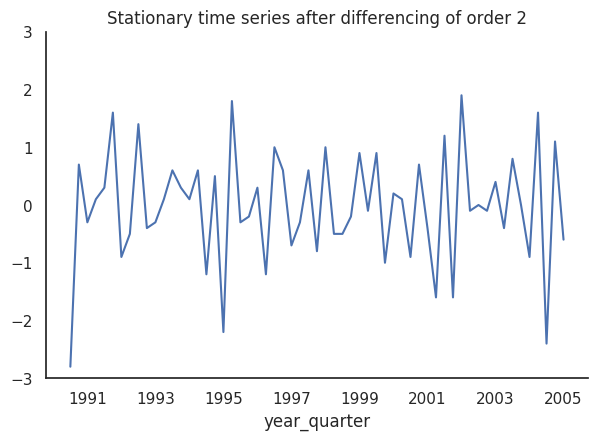

In [6]:
# differencing twice to obtain a stationary timeseries: constant in mean and variance
df['diff_order2'] = df['index'].diff().diff()
ax = df['diff_order2'].plot(title='Stationary time series after differencing of order 2')
ax.set(ylim=(-3, 3))
sns.despine();

In [7]:
# data after cleaning and differencing
df.head(3)

,index,diff_order2
year_quarter,,
1990Q1,89.300,nan
1990Q2,90.600,nan
1990Q3,89.100,-2.800


In [8]:
df.tail(3)

,index,diff_order2
year_quarter,,
2004Q3,97.500,-2.400
2004Q4,97.400,1.100
2005Q1,96.700,-0.600


## 8.1) Selecting an ARIMA model

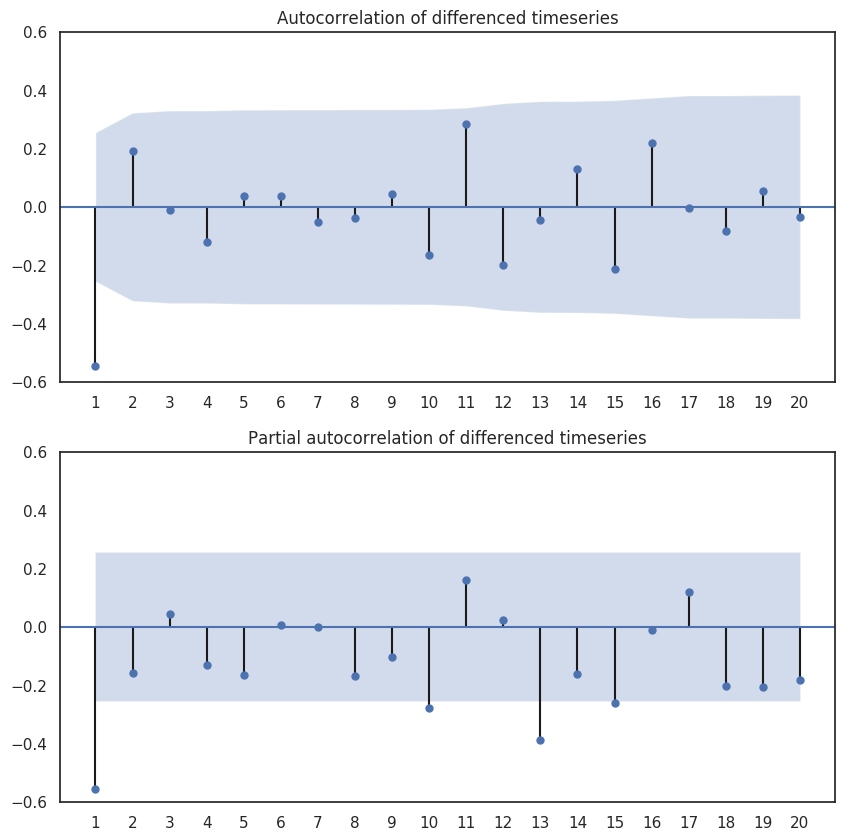

In [9]:
# We already found out that the series needs to be differenced twice to get stationary.
# Now we look at the ACF and PACF plot to figure out which ARIMA-model is a good start.

# in ACF lag 1 of difference of order 2 is significant
# in PACF lag 1 of difference of order 2 also clearly significant
# so you could use a ARIMA(0, 2, 1) model or a ARIMA(1, 2, 0) model
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
# plot_acf uses Bartlett's approx. SPSS has default a different method: independent.
plot_acf(
    df.loc['1990Q3':, 'diff_order2'], 
    lags=20, 
    zero=False, 
    unbiased=False, 
    title='Autocorrelation of differenced timeseries',
    ax=ax[0]
)
# plot_pacf uses different method than SPSS, so the results are also different: lag 13 is much more sign. than in SPSS
plot_pacf(
    df.loc['1990Q3':, 'diff_order2'], 
    lags=20, 
    zero=False, 
    title='Partial autocorrelation of differenced timeseries',
    ax=ax[1]
)

for axis in ax:
    plt.sca(axis)
    axis.set(ylim=(-0.6, 0.6))
    plt.xticks(ticks=range(1,21), labels=range(1,21));

## 8.2) Fitting and checking ARIMA models

In [10]:
# so we found that the time series needs to differenced twice and an MA-model of order 1 could be a good start,
# so now we set up our ARIMA model:

# fit the ARIMA-model of order (0, 2, 1)
arima_model = ARIMA(endog=df['index'], order=(0, 2, 1)).fit()

In [11]:
# you can get a summary of the results of the model
# the MA-component = 0.7454, but here it's shown as -0.7454, so that's different from SPSS.
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.index   No. Observations:                   59
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 -69.481
Method:                       css-mle   S.D. of innovations              0.780
Date:                Mon, 14 Jan 2019   AIC                            144.962
Time:                        11:12:58   BIC                            151.195
Sample:                    09-30-1990   HQIC                           147.395
                         - 03-31-2005                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0005      0.027     -0.019      0.985      -0.054       0.053
ma.L1.D2.index    -0.7454      0.114     -6.560      0.000      -0.968      -0.523
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.3415           +0.0000j            1.3415            0.0000
-----------------------------------------------------------------------------
"""

In [12]:
# simple overview of parameters of the ARIMA-model
# Please be aware that the MA-param of -0.745 should technically be 0.745
arima_model.params

const            -0.001
ma.L1.D2.index   -0.745
dtype: float64

In [13]:
# MA-parameters you can also get from arima model results
arima_model.maparams

array([-0.74542592])

In [14]:
# AR-parameters, since this is order (0, 2, 1) there are no AR-params
arima_model.arparams

array([], dtype=float64)

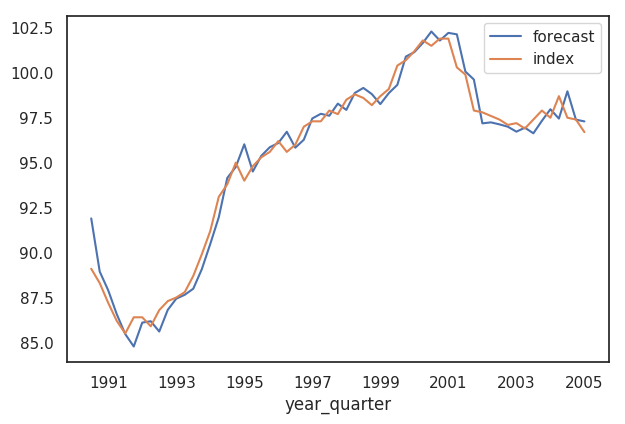

In [15]:
# class Arima Results has a method plot_predict() to check the fit.
arima_model.plot_predict();

In [16]:
# add residuals and fitted values to dataframe
# to get the real fitted values (not the differenced ones) you have to choose typ='levels' !!!
df['fitted'] = arima_model.predict(typ='levels')  
df['resid_arima'] = arima_model.resid

In [17]:
# check out fitted values and residuals
df.head(5)

,index,diff_order2,fitted,resid_arima
year_quarter,,,,
1990Q1,89.300,nan,nan,nan
1990Q2,90.600,nan,nan,nan
1990Q3,89.100,-2.800,91.899,-2.799
1990Q4,88.300,0.700,88.941,-0.641
1991Q1,87.200,-0.300,87.898,-0.698


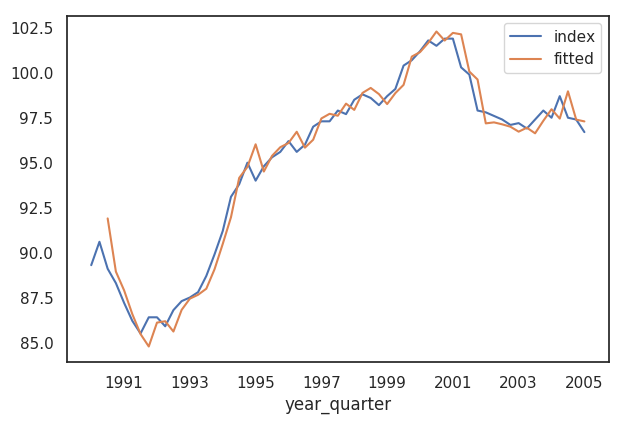

In [18]:
# plot index vs fitted values, same graph as before
df[['index', 'fitted']].plot();

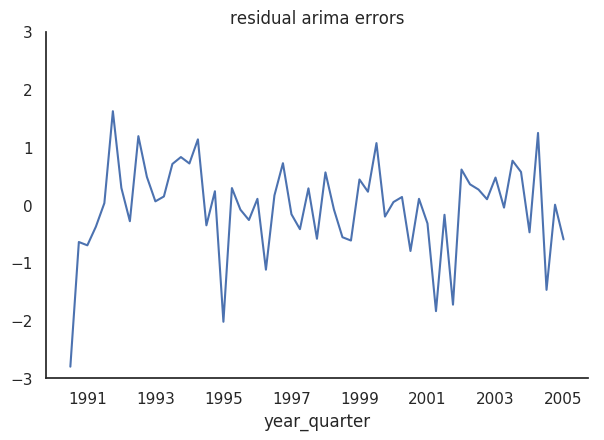

In [19]:
# errors seem to fluctuate around 0 over time with constant variance
ax = df['resid_arima'].plot(title='residual arima errors')
ax.set(ylim=(-3, 3))
sns.despine();

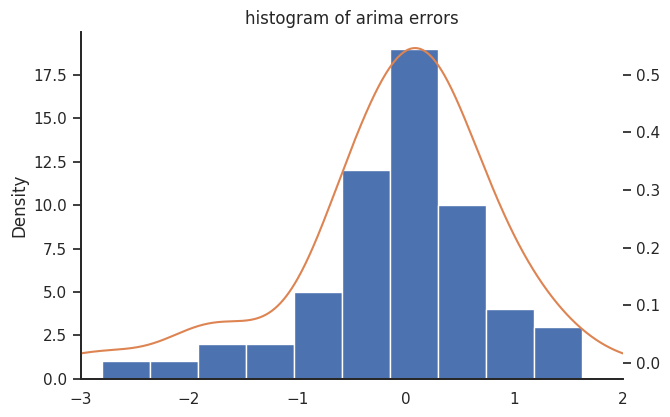

In [20]:
# errors seem normally distributed (enough) so the models seems a good fit.
fig, ax = plt.subplots(1, 1)
ax = df['resid_arima'].plot(kind='hist')
ax = df['resid_arima'].plot(kind='kde', secondary_y=True)
ax.set(xlim=(-3, 2), title='histogram of arima errors')
sns.despine();

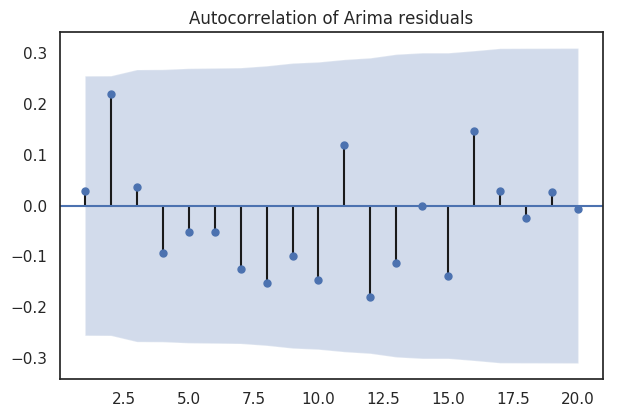

In [21]:
# no significant autocorrelation of the residual errors, so again: seems a good fit.
fig, ax = plt.subplots(1, 1)
plot_acf(df['resid_arima'].loc['1990Q3':,], lags=20, zero=False, unbiased=False, ax=ax)
ax.set(title='Autocorrelation of Arima residuals');

In [22]:
# ljung box for lag 20 gives test statistic value of 17.19 and corresponding p value of 0.64
# which also means: no significant autocorrelation
# ergo: the model is a good fit.
ljungbox_test_statistic, pvalues = acorr_ljungbox(df['resid_arima'].loc['1990Q3':,], lags=20)
print(ljungbox_test_statistic)
print(pvalues)

[ 0.04962744  3.1117591   3.19882855  3.77207387  3.95351046  4.13873499
  5.20363163  6.81900085  7.52788221  9.08281445 10.16133039 12.62688226
 13.62350731 13.62361755 15.19033672 16.99508868 17.06789797 17.1205373
 17.18283191 17.18772313]
[0.82371284 0.21100371 0.36197385 0.43773014 0.55612858 0.65790808
 0.63512854 0.55628127 0.58233168 0.52426266 0.51593649 0.39673329
 0.40088226 0.47811146 0.43779581 0.38591498 0.44977523 0.51483285
 0.57748282 0.6407525 ]


In [23]:
# You could now look at other possible ARIMA-models, for example (1, 2, 0) 
# Then you compare the fits, see if the errors are also white noise and if they
# are, then check which has the lowest RMSE (Root Mean Squared Errors)

## 8.3) Forecasting with ARIMA models

In [24]:
# Okay, so for now, we stay with our ARIMA(0, 2, 1) model because it's a good fit.
# Now we check what the forecasts will be and what the prediction limits are that go with the forecasts

# Predict future values for 2005 Q2 until 2010 Q1
predictions = arima_model.predict(start='2005Q2', end='2010Q1', typ='levels').to_frame('forecast')
predictions.head(3)

,forecast
2005Q2,96.443
2005Q3,96.186
2005Q4,95.929


In [25]:
# Get the prediction limits (= lower and upper confidence limits)
forecast, stderr, confint = arima_model.forecast(steps=20, alpha=0.05)
conf_limits = pd.DataFrame(confint, columns=['LCL', 'UCL'], index=predictions.index)
conf_limits.head(3)

/Users/sandervandenoord/miniconda2/envs/openu3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


,LCL,UCL
2005Q2,94.914,97.973
2005Q3,93.733,98.640
2005Q4,92.560,99.297


In [26]:
# putting it all together: add forecasts and prediction limits to the df
# join is always on index
df = df.join(predictions.join(conf_limits), how='outer')
df.loc['2005Q1':'2006Q3']

,index,diff_order2,fitted,resid_arima,forecast,LCL,UCL
year_quarter,,,,,,,
2005Q1,96.700,-0.600,97.296,-0.596,nan,nan,nan
2005Q2,nan,nan,nan,nan,96.443,94.914,97.973
2005Q3,nan,nan,nan,nan,96.186,93.733,98.640
2005Q4,nan,nan,nan,nan,95.929,92.560,99.297
2006Q1,nan,nan,nan,nan,95.670,91.355,99.985
2006Q2,nan,nan,nan,nan,95.412,90.106,100.717
2006Q3,nan,nan,nan,nan,95.152,88.810,101.495


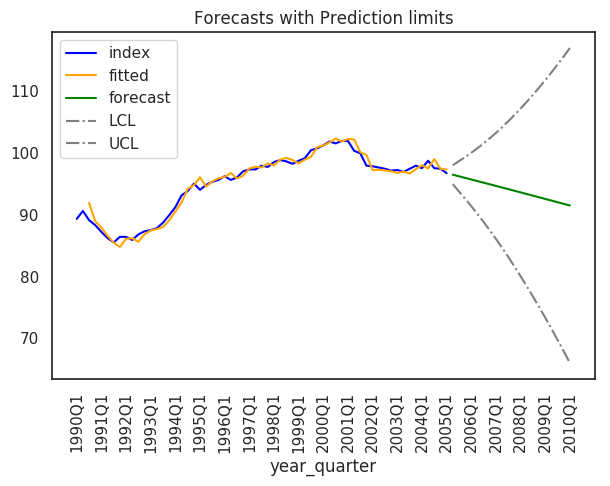

In [27]:
# You can see that if you try to predict far ahead in this set the prediction limits get very wide

# plotting forecasts with prediction limits
df[['index', 'fitted', 'forecast', 'LCL', 'UCL']].plot(
    color=['blue', 'orange', 'green', 'grey', 'grey'],
    style=['-', '-', '-', '-.', '-.'],
    title='Forecasts with Prediction limits'
)
plt.xticks(
    ticks=df.index, 
    labels=(label if nr%4==0 else '' for nr, label in enumerate(df.index)), 
    rotation=90
);